# MINE 4201- SR -  Laboratorio 1 
# Exploración modelos KNN



## Elaborado por:
* Cristian C. Moreno Mojica(c.morenom@uniandes.edu.co) 
* Juan J. Ovalle Villamil(jj.ovalle@uniandes.edu.co) 
* Maria C. Rodríguez Niño (mc.rodriguezn12@uniandes.edu.co)

### Vamos a utilizar las siguientes librerias en el laboratorio


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random
import matplotlib.pyplot as plt

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [4]:
if not (os.path.exists('content/u.data') and os.path.exists('content/u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [2]:
ratings=pd.read_csv('content/u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [3]:
items=pd.read_csv('content/u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1' )

/home/dot/anaconda3/envs/andes/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


Verifique que los ratings y los items hayan sido cargados correctamente





In [7]:
display(ratings.head(2))
items.head(2)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
# Se cambia el índice por la columna movie id
items=items.set_index(items['movie id'])
items.head(1)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

In [16]:
pd.DataFrame((ratings.rating.value_counts()/len(ratings))*100).reset_index().rename(columns= {'index':'Rating',
                                                                                             'rating':'Perc_rating'})

,Rating,Perc_rating
0,4,34.174
1,3,27.145
2,5,21.201
3,2,11.370
4,1,6.110


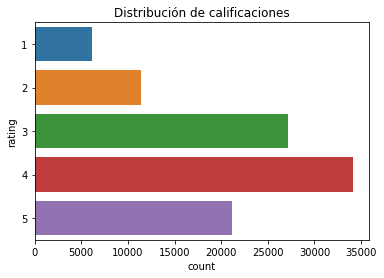

In [19]:
sns.countplot(y='rating', data=ratings)
plt.title('Distribución de calificaciones')
plt.show()

La distribución de los puntajes asignados a  las peliculas ( valores entre 1 y 5)   presentan una distribución en la cual  la mayor asiganción de puntaje  dad para el valor "4" con un 34.1% de usuarios, continuado con el puntajaje "3" con un 27%  luego el "5" con un 21.2% y por ultimos el valor de "2" con 11.3% y "1" con 6.11%. Indicando que porcentaje de califcaciones que podriamos decir como bajas corresponde al 17.48%.

## En la siguiente celda se esta calculando el número de ratings por usuario y  el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [21]:
display(ratings.groupby('user_id')['rating'].agg({'count','mean'}).sort_values(by='count', ascending=False).reset_index())

,user_id,mean,count
0,405,1.834464,737
1,655,2.908029,685
2,13,3.097484,636
3,450,3.864815,540
4,276,3.465251,518
...,...,...,...
938,685,2.050000,20
939,475,3.600000,20
940,36,3.800000,20
941,732,3.700000,20


## Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

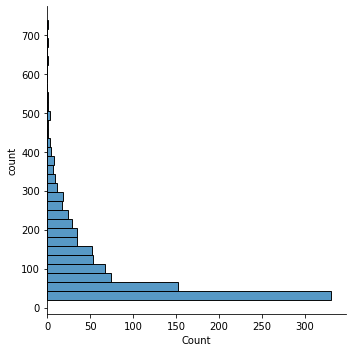

In [18]:
ratings_count = ratings.groupby('user_id')['rating'].agg({'count'}).sort_values(by='count', ascending=False)
sns.displot(y='count', data=ratings_count)
plt.show()

¿Cómo es la distribución del promedio de calificación por usuario?

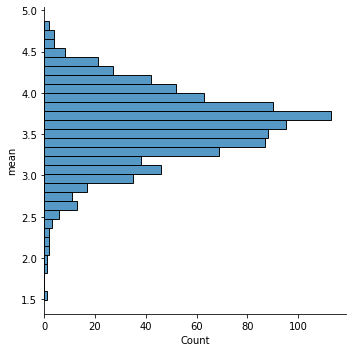

In [19]:
mean_rating = ratings.groupby('user_id')['rating'].agg({'mean'}).reset_index()
sns.displot(y='mean', data=mean_rating)
plt.show()

## En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones. 

In [26]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left').reset_index().head(3)

,item_id,mean,var,count,movie title
0,1,3.878319,0.860992,452,Toy Story (1995)
1,2,3.206107,0.934116,131,GoldenEye (1995)
2,3,3.033333,1.470787,90,Four Rooms (1995)


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?  


In [27]:
ratings.groupby('item_id').size().reset_index(name = 'conteo').sort_values(by = 'conteo', ascending = False).head(10).rename(columns= {'conteo':'Numero_calificaciones'})

,item_id,Numero_calificaciones
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485
285,286,481
287,288,478
0,1,452
299,300,431
120,121,429


¿Se puede observar el fenomeno de cola larga en este dataset?, evidencielo por medio de un gráfico

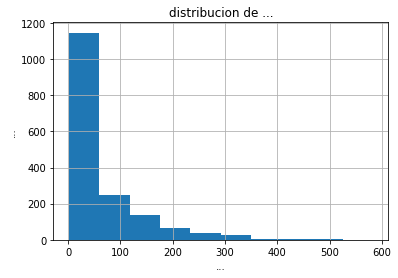

In [34]:
ratings.groupby('item_id').size().reset_index(name = 'conteo').sort_values(by = 'conteo', ascending = False).hist(column = 'conteo')
plt.title('distribucion de ...')
plt.ylabel('...')
plt.xlabel('...')
plt.show()

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos serían los mejores items del dataset y una buena lista inicial con los elementos más aclamados por los usuarios del sistema

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio? 

Cree una lista top 10 con los mejores items globales siguiendo la estrategia seleccionada

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [ ]:
### Top 10  de los items con mejores promedios

In [35]:
ratings.groupby('item_id').size().reset_index(name = 'mean').sort_values(by = 'mean', ascending = False).head(10).join(items['movie title'], how='left')

,item_id,mean,movie title
49,50,583,I.Q. (1994)
257,258,509,Men in Black (1997)
99,100,508,Snow White and the Seven Dwarfs (1937)
180,181,507,Apocalypse Now (1979)
293,294,485,Donnie Brasco (1997)
285,286,481,Secrets & Lies (1996)
287,288,478,Marvin's Room (1996)
0,1,452,NaN
299,300,431,Hoodlum (1997)
120,121,429,Striptease (1996)


In [24]:
### https://www.sciencedirect.com/science/article/pii/S1877050918308718

f = ratings.groupby('item_id')['rating'].agg({'count','mean'}).reset_index().rename(columns={'count':'numero_calificacione',
                                                                                          'mean':'promedio_calificaciones'})
def weight_item(mean,count,count_max):
    return (mean/5) *(count/count_max)
n = f.numero_calificacione.max()
f = f.assign(peso = f.apply(lambda x: weight_item(x.numero_calificacione,x.promedio_calificaciones,n),axis=1))
f.sort_values(by='peso',ascending=False).head(10).join(items['movie title'], how='left')[['movie title','numero_calificacione', 	'promedio_calificaciones', 	'peso']]

,movie title,numero_calificacione,promedio_calificaciones,peso
49,I.Q. (1994),583,4.358491,0.871698
99,Snow White and the Seven Dwarfs (1937),508,4.155512,0.724185
180,Apocalypse Now (1979),507,4.007890,0.697084
257,Men in Black (1997),509,3.803536,0.664151
173,"Princess Bride, The (1987)",420,4.252381,0.612693
126,"Spitfire Grill, The (1996)",413,4.283293,0.606861
285,Secrets & Lies (1996),481,3.656965,0.603431
0,NaN,452,3.878319,0.601372
97,Dances with Wolves (1990),390,4.289744,0.573928
287,Marvin's Room (1996),478,3.441423,0.564322


# Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [38]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [39]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [40]:
#Este es el primer elemento del dataset de prueba (usuario 154, pelicula 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [148]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [149]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

In [150]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.051373747638048, details={'actual_k': 20, 'was_impossible': False})

In [151]:
ratings[(ratings.user_id == 154) & (ratings.item_id==302)]['rating'].values[0]

4

Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [152]:
test_predictions=algo.test(test_set)

In [153]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=350, iid=211, r_ui=2.0, est=4.6008126925768735, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=292, iid=607, r_ui=4.0, est=4.298309362254628, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=929, iid=12, r_ui=4.0, est=3.9521095214177917, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=342, iid=523, r_ui=4.0, est=2.644893360533666, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=239, iid=650, r_ui=5.0, est=4.650462655546957, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [154]:
# En promedio, el sistema encuentra ratings que estan una estrella por encima o por debajo del rating del usuario
accuracy.rmse( test_predictions, verbose = True )

RMSE: 1.0590


1.0590073323808569

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?


In [67]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': True  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(trainset=train_set)
test_predictions=algo.test(test_set)
accuracy.rmse( test_predictions, verbose = True )

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0166


1.0166414414593592

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ? 

Pruebe para un número diferente de vecinos (e.j 5, 10, 20, 50, 100)

In [65]:
### convertirlo en una tabla
tabla = pd.DataFrame()
for i in range(2,100,10):
  sim_options = {'name': 'cosine',
                'user_based': True  # calcule similitud item-item
                }
  algo = KNNBasic(k=i, min_k=2, sim_options=sim_options)
  algo.fit(trainset=train_set)
  tabla.loc[i,'predict']= (algo.predict(154,302).est)
tabla.reset_index().rename(columns={'index':'k'})

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


,k,predict
0,2,4.500000
1,12,4.416667
2,22,4.318182
3,32,4.187538
4,42,4.238004
5,52,4.269073
6,62,4.290042
7,72,4.222369
8,82,4.195464
9,92,4.206700


## Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [69]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [71]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [72]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [73]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [74]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [76]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)
df_predictions

,movie id,estimation
0,1309,4.500000
1,1310,4.500000
2,1676,4.250000
3,1675,4.250000
4,1289,4.202436
5,1643,4.097226
6,1593,4.090909
7,935,4.051367
8,1216,4.050692
9,1312,4.049247


In [49]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie title','IMDb URL ']], how='left', right_index=True, left_on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

In [268]:
new_user = pd.read_csv('content/Datos_usuarios_nuevos.csv',sep=',',usecols=['user_id','item_id','rating'])
ratings_new = ratings.append(new_user)
items_melt = pd.melt(items[['movie id','unknown', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western']], id_vars='movie id', var_name='genero')
items_melt = items_melt[items_melt.value==1]
items_melt = items_melt.groupby(['movie id']).agg({'genero': lambda x: '|'.join(x)}).reset_index()
items_melt = items_melt.merge(items[['movie title']],on='movie id', how ='inner')

In [50]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings_new[ [ 'user_id', 'item_id', 'rating' ] ], reader )
train_set, test_set=  train_test_split(surprise_dataset, test_size=.3)

In [124]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### usuario 944

In [52]:
user_predictions_944=list(filter(lambda x: x[0]==944,predictions))
user_predictions_944.sort(key=lambda x : x.est, reverse=True)
labels = ['movie id', 'estimation']
user_predictions_944 = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions_944)), columns=labels)
user_predictions_944.merge(items_melt,on='movie id',how='inner').head(10)

,movie id,estimation,genero,movie title
0,1504,5.000000,Comedy,"Bewegte Mann, Der (1994)"
1,1606,5.000000,Crime,Deceiver (1997)
2,1080,4.500000,Comedy,Celestial Clockwork (1994)
3,1130,4.500000,Documentary,Jupiter's Wife (1994)
4,1294,4.333333,Documentary,Ayn Rand: A Sense of Life (1997)
5,1526,4.333333,Drama -Romance -Thriller,Witness (1985)
6,1677,4.333333,Drama,Sweet Nothing (1995)
7,1241,4.200000,Comedy -Drama,"Van, The (1996)"
8,1682,4.000000,Drama,Scream of Stone (Schrei aus Stein) (1991)
9,1251,3.946101,Comedy,A Chef in Love (1996)


### usuario 945

In [53]:
user_predictions_945 = list(filter(lambda x: x[0]==945,predictions))
user_predictions_945.sort(key=lambda x : x.est, reverse=True)
labels = ['movie id', 'estimation']
user_predictions_945 = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions_945)), columns=labels)
user_predictions_945.merge(items_melt,on='movie id',how='inner').head(10)

,movie id,estimation,genero,movie title
0,1602,5.000000,Drama,"Price Above Rubies, A (1998)"
1,1596,4.666667,Action -Sci-Fi -Thriller,Nemesis 2: Nebula (1995)
2,1595,4.666667,Action -Thriller,Shopping (1994)
3,1436,4.500000,Drama -Romance,Mr. Jones (1993)
4,1616,4.500000,Drama,Desert Winds (1995)
5,1677,4.500000,Drama,Sweet Nothing (1995)
6,1679,4.500000,Romance -Thriller,B. Monkey (1998)
7,1678,4.500000,Drama,Mat' i syn (1997)
8,1680,4.500000,Drama -Romance,Sliding Doors (1998)
9,1526,4.428571,Drama -Romance -Thriller,Witness (1985)


¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

In [54]:
item_raking = ratings.groupby('item_id').size().reset_index(name = 'conteo').sort_values(by = 'conteo', ascending = False)
item_raking = item_raking[item_raking.conteo >= item_raking.conteo.quantile(0.75)].rename(columns= {'item_id':'movie id'})
items_tail = item_raking.merge(items_melt,on='movie id',how='inner')

In [304]:
len(items_tail[(items_tail['movie id'].isin(user_predictions_944.head(50)['movie id']))])/50

0.0

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

/home/dot/anaconda3/envs/andes/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


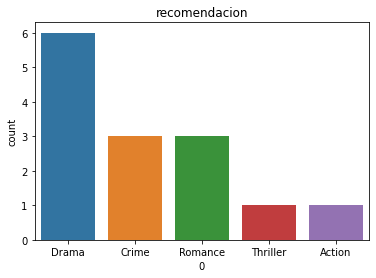

In [291]:
A =user_predictions_120.merge(items_melt,on='movie id',how='inner').head(10)['genero'].apply(lambda x: x.split('|'))
def list_x(A):
    f = pd.DataFrame()
    for j in range(len(A)):
         f = f.append(pd.DataFrame([i for i in A[j]]))
    return f
        
sns.countplot(list_x(A).iloc[:,0])
plt.title('recomendacion')
plt.show()

/home/dot/anaconda3/envs/andes/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


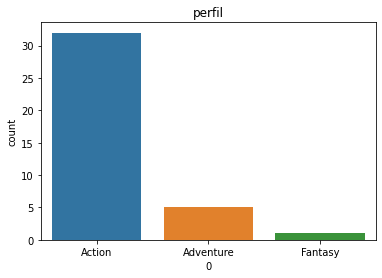

In [301]:
A = new_user[new_user.user_id == 944].merge(items_melt,left_on ='item_id' ,right_on='movie id',how='inner')['genero'].apply(lambda x: x.split('|'))
sns.countplot(list_x(A).iloc[:,0])
plt.title('perfil')
plt.show()

In [146]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs


def evaluate_predictions(name, algo, train, test):
    algo_cloned = util.clone(algo)
    algo_cloned.fit(train)
    return test.assign(preds=algo_cloned.predict(test), algo=name)

from lenskit import crossfold as xf
from lenskit import batch, topn, util
from lenskit.algorithms import Recommender, als, item_knn as knn
import lenskit.metrics.predict as pm

In [155]:
ratings_test = ratings.rename(columns={'user_id':'user',
                           'item_id':'item'})
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset_test = Dataset.load_from_df( ratings_test[ [ 'user', 'item', 'rating' ] ], reader )
train_set, test_set=  train_test_split(surprise_dataset_test, test_size=.3)
algo_ii = knn.ItemItem(20,2)
ratings_test = ratings_test.reset_index(drop=True)

In [160]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings_test[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))

In [161]:
all_recs_ = pd.concat(all_recs, ignore_index=True)
all_recs_[all_recs_.user==196].merge(items_melt,left_on='item', right_on='movie id',how='inner').head(10)

,item,score,user,rank,Algorithm,movie id,genero,movie title
0,1125,4.899434,196,1,ItemItem,1125,Thriller,"Innocents, The (1961)"
1,64,4.870923,196,2,ItemItem,64,Drama,"Shawshank Redemption, The (1994)"
2,318,4.770242,196,3,ItemItem,318,Drama -War,Schindler's List (1993)
3,603,4.761626,196,4,ItemItem,603,Mystery -Thriller,Rear Window (1954)
4,357,4.734038,196,5,ItemItem,357,Drama,One Flew Over the Cuckoo's Nest (1975)
5,134,4.693841,196,6,ItemItem,134,Drama,Citizen Kane (1941)
6,178,4.688947,196,7,ItemItem,178,Drama,12 Angry Men (1957)
7,483,4.667305,196,8,ItemItem,483,Drama -Romance -War,Casablanca (1942)
8,1443,4.620770,196,9,ItemItem,1443,Drama,8 Seconds (1994)
9,114,4.612707,196,10,ItemItem,114,Animation,Wallace & Gromit: The Best of Aardman Animatio...


In [162]:
preds_itemitem = pd.concat(evaluate_predictions('itemitem', algo_ii, train, test) for (train, test) in xf.partition_users(ratings_test, 5, xf.SampleFrac(0.2)))
print(f'RMSE: {pm.rmse(preds_itemitem.preds, preds_itemitem.rating)}')

RMSE: 0.9063172389760574
